In [1]:
w_python = !which python
if 'home' in w_python[0]:
    resources_prefix = ''
else:
    !pip install watermark unidecode
    !python -m spacy download es_core_news_sm

    from google.colab import drive
    drive.mount('/content/drive')

    resources_prefix = '/content/drive/MyDrive/Machine Learning/Notebooks/0501_NLP - News Classifier/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 38.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 800 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
Mounted at /content/drive


In [2]:
# !conda install -y watermark

In [3]:
%load_ext watermark
%watermark

Last updated: 2022-08-06T14:24:24.381739+00:00

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.188+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [4]:
import spacy
import pandas as pd

import os

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np

import re

import unidecode

import dill

from wordcloud import WordCloud

import string
from string import punctuation

from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, Bidirectional, Conv1D, MaxPooling1D, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.constraints import maxnorm
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.platform import build_info as build
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import nltk  # Natural language toolkit
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')  # stopwords
stopwords = stopwords.words('spanish')

# nlp = spacy.load('es_core_news_lg')  # large
nlp = spacy.load('es_core_news_sm') # small
# nlp = spacy.load('en_core_web_lg') # large
# nlp = spacy.load('en_core_web_sm')  # small

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Resume

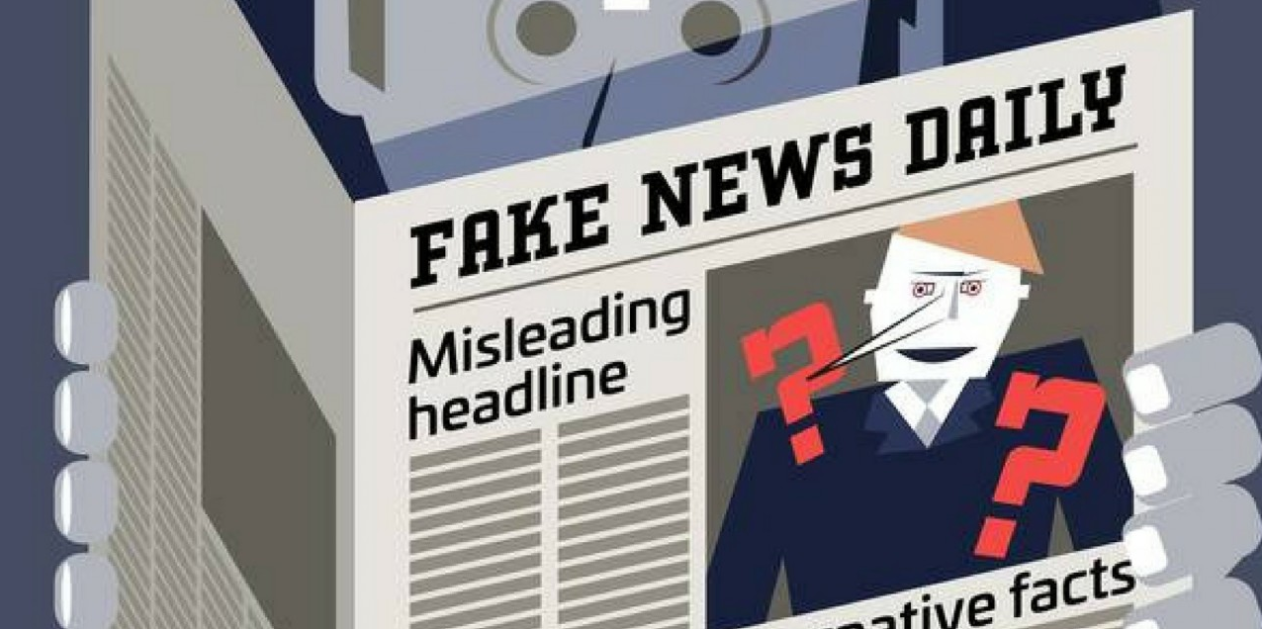

## Data Collection

In [5]:
sns.set_style("whitegrid")

In [6]:
df = pd.read_csv(f'{resources_prefix}_resources/noticias.csv')
df.head(10)

,descripcion,categoria
0,"Aunque parezca mentira, las emisiones de dióxi...",cultura
1,Hubo un proyecto impulsado por la Unión Europe...,cultura
2,China ha confirmado la conclusión con éxito de...,tecnología
3,"En su fructífera carrera como humorista, actor...",cultura
4,Tras dos años de negociación entre la instituc...,cultura
5,Vídeo en Pyongyang de un hombre comprando en t...,ocio
6,Mi problema es que decido dónde viajar usando ...,cultura
7,Cómo se recuperó una lengua originaria de Amér...,cultura
8,"Ejecutivos de HP, Canon, Epson y Brother podrí...",tecnología
9,Los arqueólogos han descubierto una prueba que...,cultura


## Data Wrangling

In [7]:
df.dtypes   # Tipos de variables

descripcion    object
categoria      object
dtype: object

Feature and dependent column.

In [8]:
feature_column = 'descripcion'
target_column = 'target'

For best model performance, dependent classes should start at 0 and not 1.

In [9]:
df.loc[(df['categoria'] == 'cultura'), target_column] = 0
df.loc[(df['categoria'] == 'tecnología'), target_column] = 1
df.loc[(df['categoria'] == 'ocio'), target_column] = 2

df[target_column] = df[target_column].astype('category')

df.head(10)

,descripcion,categoria,target
0,"Aunque parezca mentira, las emisiones de dióxi...",cultura,0.0
1,Hubo un proyecto impulsado por la Unión Europe...,cultura,0.0
2,China ha confirmado la conclusión con éxito de...,tecnología,1.0
3,"En su fructífera carrera como humorista, actor...",cultura,0.0
4,Tras dos años de negociación entre la instituc...,cultura,0.0
5,Vídeo en Pyongyang de un hombre comprando en t...,ocio,2.0
6,Mi problema es que decido dónde viajar usando ...,cultura,0.0
7,Cómo se recuperó una lengua originaria de Amér...,cultura,0.0
8,"Ejecutivos de HP, Canon, Epson y Brother podrí...",tecnología,1.0
9,Los arqueólogos han descubierto una prueba que...,cultura,0.0


In [10]:
target_names = df.categoria.unique()
target_names

array(['cultura', 'tecnología', 'ocio'], dtype=object)

In [11]:
df[target_column].unique()

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


[0.0, 1.0, 2.0]
Categories (3, float64): [0.0, 1.0, 2.0]

## Data Cleaning

### Duplicate Records

The records that are identical in all their columns are verified.

In [12]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
16490    False
16491    False
16492    False
16493    False
16494    False
Length: 16495, dtype: bool

In [13]:
duplicated = df[df.duplicated()].shape  # Cuántos records están duplicados
duplicated

(128, 3)

View duplicate records.

In [14]:
df[df.duplicated(keep=False)]

,descripcion,categoria,target
0,"Aunque parezca mentira, las emisiones de dióxi...",cultura,0.0
1,Hubo un proyecto impulsado por la Unión Europe...,cultura,0.0
2,China ha confirmado la conclusión con éxito de...,tecnología,1.0
3,"En su fructífera carrera como humorista, actor...",cultura,0.0
4,Tras dos años de negociación entre la instituc...,cultura,0.0
...,...,...,...
15654,El,cultura,0.0
16066,Viñeta de Raúl Salazar,ocio,2.0
16083,Viñeta de Bernardo Vergara.,ocio,2.0
16123,"""",ocio,2.0


In [15]:
if duplicated[0] > 0:
    print('There are duplicate records.')
else:
    print('There are no duplicate records.')

There are duplicate records.


We use the pandas `drop_duplicates` function to remove duplicate records.

In [16]:
df.drop_duplicates(keep='first', inplace=True)
df.shape

(16367, 3)

### Cardinality

If a column has the same value always (> 90%), that column can be deleted.

In [17]:
n_records = len(df)


def duplicate_column_values(df):
    resume = pd.DataFrame(columns=['VARIABLE', 'LESS_COMMON', '% LESS_COMMON', 'MORE_COMMON', '% MORE_COMMON', 'DATA_TYPE'])

    for columna in df:
        n_per_value = df[columna].value_counts()
        more_common = n_per_value.iloc[0]
        less_common = n_per_value.iloc[-1]

        new_df = pd.DataFrame(data={'VARIABLE': [columna],
                                    'LESS_COMMON': [less_common],
                                    '% LESS_COMMON': [round(less_common * 100 / (1.0 * n_records), 3)],
                                    'MORE_COMMON': [more_common],
                                    '% MORE_COMMON': [round(more_common * 100 / (1.0 * n_records), 3)],
                                    'DATA_TYPE': [df[columna].dtype]})

        resume = pd.concat([resume, new_df], ignore_index=True)

    return resume


resume = duplicate_column_values(df)
resume

,VARIABLE,LESS_COMMON,% LESS_COMMON,MORE_COMMON,% MORE_COMMON,DATA_TYPE
0,descripcion,1,0.006,2,0.012,object
1,categoria,3192,19.503,8981,54.873,object
2,target,3192,19.503,8981,54.873,category


In [18]:
resume = resume.loc[resume['% MORE_COMMON'] > 90.]
resume

,VARIABLE,LESS_COMMON,% LESS_COMMON,MORE_COMMON,% MORE_COMMON,DATA_TYPE


In [19]:
if resume.loc[resume['% MORE_COMMON'] > 90.].size == 0:
    print('No field contains more than 90% of its data repeated.')
else:
    print('Some fields contain more than 90% of their data repeated. They must be removed.')

No field contains more than 90% of its data repeated.


### Missing Values

Completely empty columns are removed.

In [20]:
df.dropna(axis=1, how='all', inplace=True)

Completely empty rows are removed.

In [21]:
df.dropna(axis=0, how='all', inplace=True)

# In case you want to delete the row if any of its values is missing, use 'any' in the 'how' parameter
# Use subset['col1', 'col2'] if you want to apply to some columns only.

## Data Visualization

### Summarize Data Lenght


Media de palabras: 342.36
Desviación estandard: 153.41


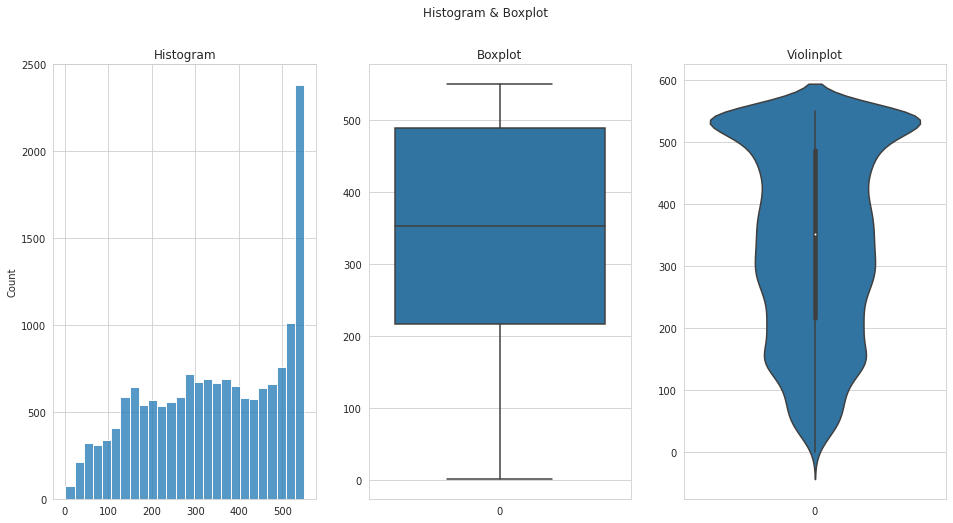

In [22]:
def summarize_data_lenght(data):
    cc = [len(x) for x in data]

    print(f'\nMedia de palabras: {round(np.mean(cc), 2)}')
    print(f'Desviación estandard: {round(np.std(cc), 2)}')

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
    fig.suptitle('Histogram & Boxplot')

    sns.histplot(data=cc, ax=axes[0])
    axes[0].set_title('Histogram')

    sns.boxplot(data=cc, ax=axes[1])
    axes[1].set_title('Boxplot')

    sns.violinplot(data=cc, ax=axes[2])
    axes[2].set_title('Violinplot')


summarize_data_lenght(data=df[feature_column])

### Frequency Distribution

In [23]:
sentences = [doc.split() for doc in df[feature_column]]
tokenized_word = np.concatenate(sentences).tolist()

filtered_review = []
for word in tokenized_word:
    # Elimina las tildes y las ñ
    word = unidecode.unidecode(word)

    # Elimina los caracteres especiales
    word = re.sub(r'[^a-z0-9]', '', word.lower()).strip()

    # Stop Words Removal
    if word not in stopwords:
        filtered_review.append(word)

filtered_review = filter(lambda val: val != '', filtered_review)
filtered_review = list(filtered_review)
filtered_review[:20]

['aunque',
 'parezca',
 'mentira',
 'emisiones',
 'dioxido',
 'carbono',
 'co2',
 'nitrogeno',
 'atmosfericos',
 'actuado',
 'fertilizante',
 'hecho',
 'tierra',
 'hoy',
 'mas',
 'verde',
 'hace',
 '30',
 'anos',
 'acabando']

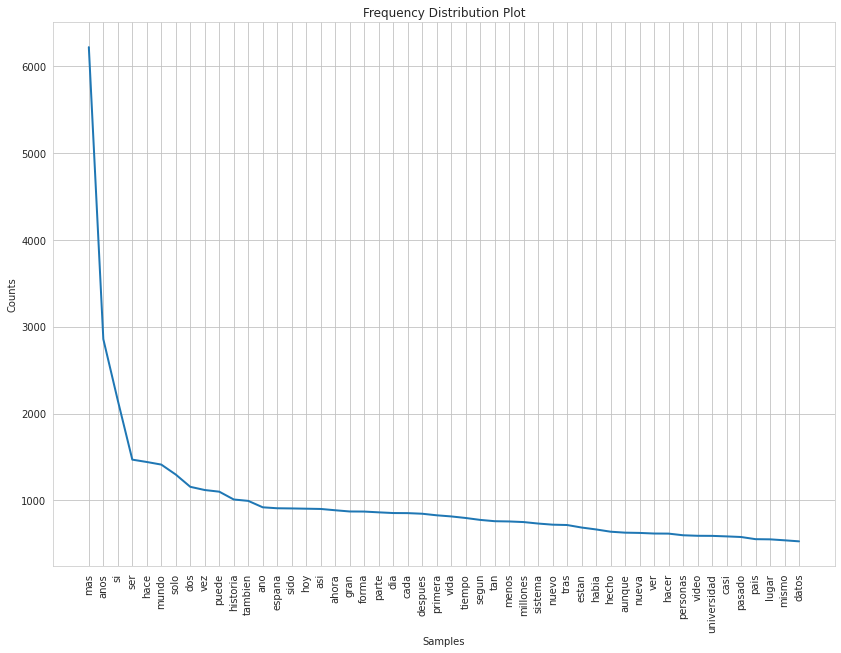

In [24]:
plt.figure(figsize=(14, 10))

fdist = FreqDist(filtered_review)
fdist.plot(50, cumulative=False, title='Frequency Distribution Plot')

plt.show()

### Word Cloud

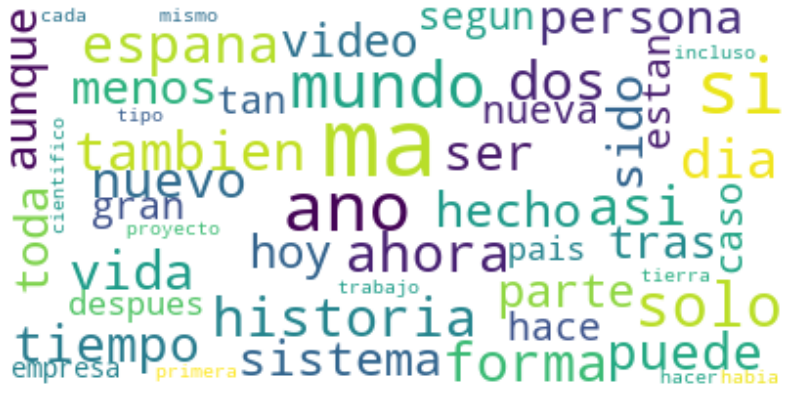

In [25]:
plt.figure(figsize=(14, 10))

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(' '.join(filtered_review))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Machine Learning

### Data Selection

In [26]:
features_data = df[feature_column]
target_data = df[target_column]

features_data[:10]

0    Aunque parezca mentira, las emisiones de dióxi...
1    Hubo un proyecto impulsado por la Unión Europe...
2    China ha confirmado la conclusión con éxito de...
3    En su fructífera carrera como humorista, actor...
4    Tras dos años de negociación entre la instituc...
5    Vídeo en Pyongyang de un hombre comprando en t...
6    Mi problema es que decido dónde viajar usando ...
7    Cómo se recuperó una lengua originaria de Amér...
8    Ejecutivos de HP, Canon, Epson y Brother podrí...
9    Los arqueólogos han descubierto una prueba que...
Name: descripcion, dtype: object

### Standardization

In [27]:
class MyStandardizationTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        array = X.values

        corpus = []

        for i in range(0, len(array)):
            doc = nlp(array[i])

            # lemmatizer and lower and strip and is_alpha and no is_stop (spacy)
            tokens = [tok.lemma_.lower().strip() for tok in doc if tok.is_alpha == True and tok.is_stop == False]

            # stopwords and punctuation (nltk)
            tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuation]

            tokens = ' '.join(tokens)

            corpus.append(tokens)

            print("\rTransforming data: {0} of {1}".format(i+1, len(array)), end='')

        corpus = pd.Series(data=corpus)

        return corpus

Se cargan los datos ya limpios (si existen), caso contrario ejecutar el algoritmo anterior.

0    parecer mentira emisión dióxido carbono nitróg...
1    proyecto impulsado unión europea universidad l...
2    china confirmar conclusión éxito operación imp...
dtype: object


Media de palabras: 201.28
Desviación estandard: 91.36


None

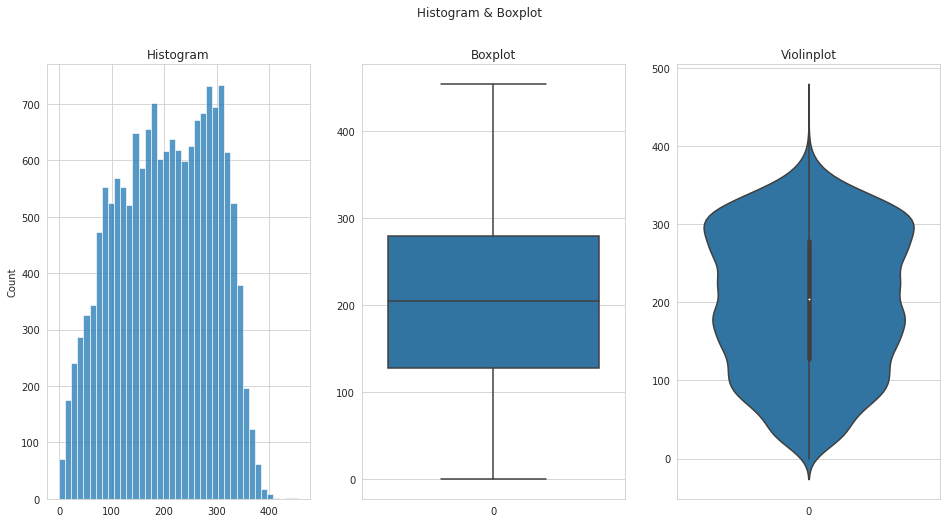

In [28]:
try:
    pkl_filename = f'{resources_prefix}_resources/corpus_cleaned.pkl'

    with open(pkl_filename, 'rb') as file:
        corpus = pickle.load(file)
except:
    standardization = MyStandardizationTransformer()
    corpus = standardization.fit_transform(features_data)

    with open(pkl_filename, 'wb') as file:
        pickle.dump(corpus, file)
finally:
    display(corpus[:3])
    display(summarize_data_lenght(data=corpus))

Se eliminan los elementos vacíos.

In [29]:
empty_indexs = [i for i, text in enumerate(corpus) if text == '']

corpus = corpus.drop(index=empty_indexs).values
target_data = target_data.drop(index=empty_indexs).values

len(corpus), len(target_data)

(16352, 16352)

### Vectorizer

#### CountVectorizer

https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/

In [30]:
# CountVectorizer acepta parámetros para realizar la limpieza de los datos realizada manualmente en la sesión anterior.
# La limpieza manual es mejor porque se puede limpiar otros detalles más adelante.
# Máxima cantidad de columnas. Se seleccionarán las palabras que más frecuencias tengan.
# Por ejemplo, si aparece un nombre o apellido es probable que solo tenga una frecuencia, esa columna no es relevante.
# TfidfVectorizer es mejor que CountVectorizer porque no solo analiza la cantidad de repeticiones de una palabra,
# sino la importancia de su aparición.
count_vectorizer = CountVectorizer(analyzer='word', max_features=None)  # Palabras con más importancia (probar varias opciones)

# Se obtiene la matriz dispersa: en las filas las valoraciones y en las columnas las frecuencias
count_vector = count_vectorizer.fit_transform(corpus)

Vocabulary.

In [38]:
count_vect_vocabulary = count_vectorizer.vocabulary_
display(list(count_vect_vocabulary.items())[:10])

del count_vect_vocabulary

[('parecer', 29987),
 ('mentira', 26084),
 ('emisión', 13786),
 ('dióxido', 12696),
 ('carbono', 6613),
 ('nitrógeno', 28313),
 ('atmosférico', 3447),
 ('actuar', 513),
 ('fertilizante', 16532),
 ('tierra', 39552)]

Vectors.

In [39]:
display(count_vector.shape)
display(count_vector)

(16352, 43392)

<16352x43392 sparse matrix of type '<class 'numpy.int64'>'
	with 381689 stored elements in Compressed Sparse Row format>

Se obtienen los vectores.

In [40]:
print(corpus[0])
count_vectorizer_df = pd.DataFrame(data=count_vectorizer.transform([corpus[0]]).toarray(), columns=count_vectorizer.get_feature_names_out())

# Se Seleccionan solamente las columnas (palabras) del texto, caso contrario se observarían muchos 0s.
display(count_vectorizer_df[corpus[0].split()])

del count_vectorizer_df

parecer mentira emisión dióxido carbono nitrógeno atmosférico actuar fertilizante tierra verde año acabar ecosistema terrestre saturar encaminar época calentamiento principal conclusión estudio internacional publicado nature ecology evolution trabajo avisar tierra pasar época fertilización calentamiento


,parecer,mentira,emisión,dióxido,carbono,nitrógeno,atmosférico,actuar,fertilizante,tierra,...,nature,ecology,evolution,trabajo,avisar,tierra,pasar,época,fertilización,calentamiento
0,1,1,1,1,1,1,1,1,1,2,...,1,1,1,1,1,2,1,2,1,2


#### TfidfVectorizer

In [41]:
# TfidfVectorizer acepta parámetros para realizar la limpieza de los datos realizada manualmente en la sesión anterior.
# La limpieza manual es mejor porque se puede limpiar otros detalles más adelante.
# Máxima cantidad de columnas. Se seleccionarán las palabras que más frecuencias tengan.
# Por ejemplo, si aparece un nombre o apellido es probable que solo tenga una frecuencia, esa columna no es relevante.
tfidf_vectorizer = TfidfVectorizer(analyzer='word', max_features=None)  # Palabras con más importancia (probar varias opciones)

# Se obtiene la matriz dispersa: en las filas las valoraciones y en las columnas las frecuencias
# vector será nuestra variable independiente
# Se convierte a array porque es una matriz sparse
tfidf_vector = tfidf_vectorizer.fit_transform(corpus)

Vocabulary.

In [43]:
tfidf_vocabulary = tfidf_vectorizer.vocabulary_
display(list(tfidf_vocabulary.items())[:10])

del tfidf_vocabulary

[('parecer', 29987),
 ('mentira', 26084),
 ('emisión', 13786),
 ('dióxido', 12696),
 ('carbono', 6613),
 ('nitrógeno', 28313),
 ('atmosférico', 3447),
 ('actuar', 513),
 ('fertilizante', 16532),
 ('tierra', 39552)]

Vectors.

In [44]:
display(tfidf_vector.shape)
display(tfidf_vector)

(16352, 43392)

<16352x43392 sparse matrix of type '<class 'numpy.float64'>'
	with 381689 stored elements in Compressed Sparse Row format>

Se obtienen los vectores.

In [45]:
print(corpus[0])
tfidf_vectorizer_df = pd.DataFrame(data=tfidf_vectorizer.transform([corpus[0]]).toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Se Seleccionan solamente las columnas (palabras) del texto, caso contrario se observarían muchos 0s.
display(tfidf_vectorizer_df[corpus[0].split()])

del tfidf_vectorizer_df

parecer mentira emisión dióxido carbono nitrógeno atmosférico actuar fertilizante tierra verde año acabar ecosistema terrestre saturar encaminar época calentamiento principal conclusión estudio internacional publicado nature ecology evolution trabajo avisar tierra pasar época fertilización calentamiento


,parecer,mentira,emisión,dióxido,carbono,nitrógeno,atmosférico,actuar,fertilizante,tierra,...,nature,ecology,evolution,trabajo,avisar,tierra,pasar,época,fertilización,calentamiento
0,0.115616,0.168581,0.145602,0.180244,0.158545,0.183716,0.181346,0.164931,0.220615,0.214282,...,0.159873,0.23703,0.220615,0.106751,0.163297,0.214282,0.098922,0.237376,0.227428,0.358383


### Cross Validation

Confusion Matrix.

In [46]:
def show_confusion_matrix(estimator, X, y):
    titles_options = {"Confusion Matrix": None, "Normalized Confusion Matrix": 'true'}

    f, axes = plt.subplots(1, len(titles_options), figsize=(12, 6), sharey='row')

    for i, (title, normalize) in enumerate(titles_options.items()):
        disp = ConfusionMatrixDisplay.from_estimator(estimator, X, y, display_labels=target_names, cmap=plt.cm.Blues, normalize=normalize, ax=axes[i])
        disp.ax_.set_title(title)

    plt.show()

In [47]:
def my_cross_validate(estimator, X, y, show_msg):
    scores = cross_validate(estimator=estimator, X=X, y=y, scoring='accuracy', cv=3, n_jobs=-1, return_train_score=True)

    estimator.fit(X, y)  # To return the already adjusted estimator.

    score = round(scores['test_score'].mean(), 4)

    if show_msg == True:
        print(f'The model has a degree of accuracy of {score * 100}%.')
        show_confusion_matrix(estimator, X, y)

    return estimator, score

In [48]:
def my_grid_search_cv(estimator, X, y, param_grid, show_msg):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, return_train_score=True)
    grid_search.fit(X, y)
    estimator = grid_search.best_estimator_

    score = round(grid_search.best_score_, 4)

    if show_msg == True:
        print(f'The model has a degree of accuracy of {score * 100}%.')
        show_confusion_matrix(estimator, X, y)

    return estimator, score

The dataframe for the evaluation results of each algorithm is defined.

In [49]:
results = pd.DataFrame(columns=['MODEL', 'ACCURACY', 'ESTIMATOR'])

### Logistic Regression

The model has a degree of accuracy of 68.16%.


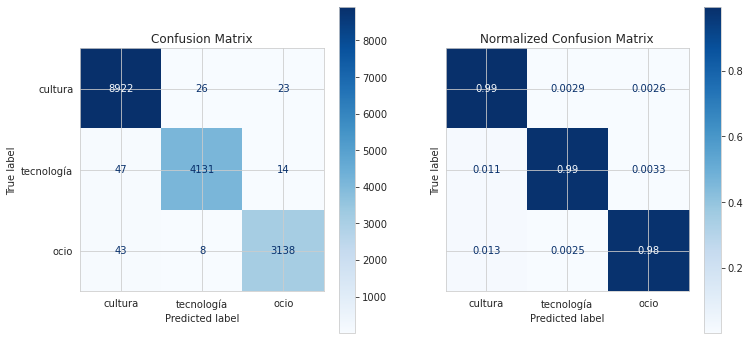

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.6816,"(CountVectorizer(), LogisticRegression(max_ite..."


The model has a degree of accuracy of 71.00999999999999%.


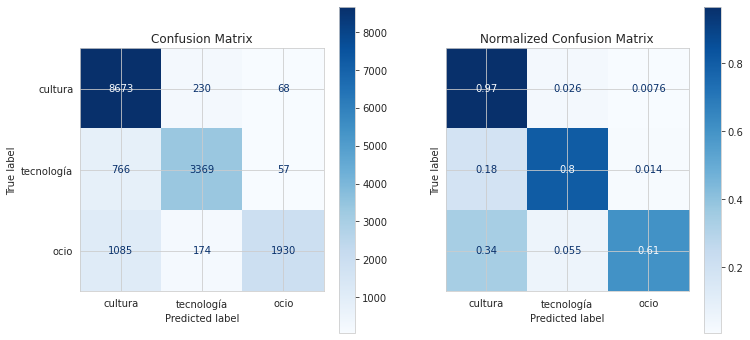

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.6816,"(CountVectorizer(), LogisticRegression(max_ite..."
1,logistic,0.7101,"(TfidfVectorizer(), LogisticRegression(max_ite..."


In [50]:
def my_logistic_regression(results, features_data, target_data, vectorizer, show_msg=False):
    input = [('vectorizer', vectorizer(analyzer='word', max_features=None)), ('model', LogisticRegression(max_iter=300))]

    estimator, score = my_cross_validate(estimator=Pipeline(steps=input), X=features_data, y=target_data, show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['logistic'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, clf = my_logistic_regression(results, corpus, target_data, CountVectorizer, True)
display(results)

results, clf = my_logistic_regression(results, corpus, target_data, TfidfVectorizer, True)
display(results)

### Naive Bayes

#### Multinomial Naive Bayes

The model has a degree of accuracy of 72.11%.


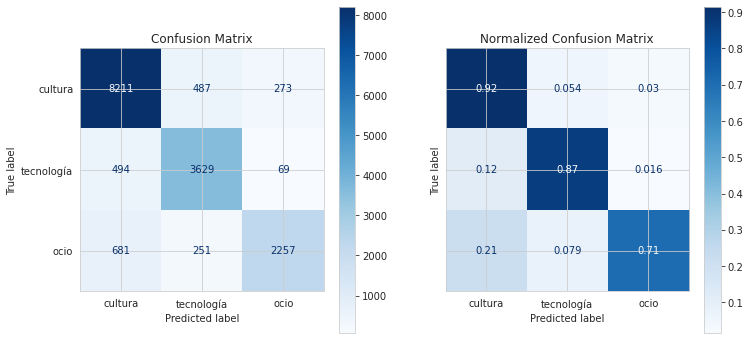

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.6816,"(CountVectorizer(), LogisticRegression(max_ite..."
1,logistic,0.7101,"(TfidfVectorizer(), LogisticRegression(max_ite..."
2,multinomial_nb,0.7211,"(CountVectorizer(), MultinomialNB())"


The model has a degree of accuracy of 65.10000000000001%.


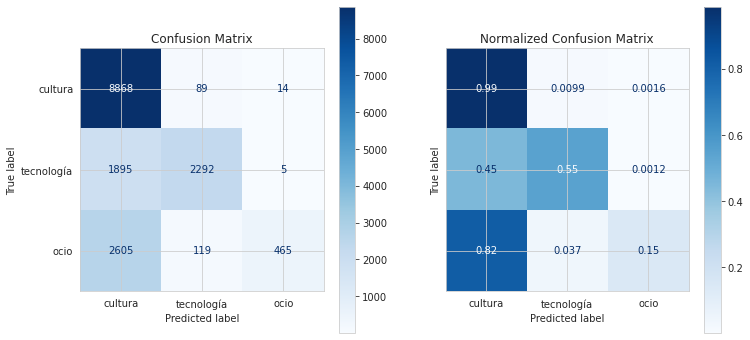

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.6816,"(CountVectorizer(), LogisticRegression(max_ite..."
1,logistic,0.7101,"(TfidfVectorizer(), LogisticRegression(max_ite..."
2,multinomial_nb,0.7211,"(CountVectorizer(), MultinomialNB())"
3,multinomial_nb,0.6510,"(TfidfVectorizer(), MultinomialNB())"


In [51]:
def my_multinomial_nb(results, features_data, target_data, vectorizer, show_msg=False):
    input = [('vectorizer', vectorizer(analyzer='word', max_features=None)), ('model', MultinomialNB())]

    estimator, score = my_cross_validate(estimator=Pipeline(steps=input), X=features_data, y=target_data, show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['multinomial_nb'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, clf = my_multinomial_nb(results, corpus, target_data, CountVectorizer, True)
display(results)

results, clf = my_multinomial_nb(results, corpus, target_data, TfidfVectorizer, True)
display(results)

#### Bernoulli Naive Baye

The model has a degree of accuracy of 69.51%.


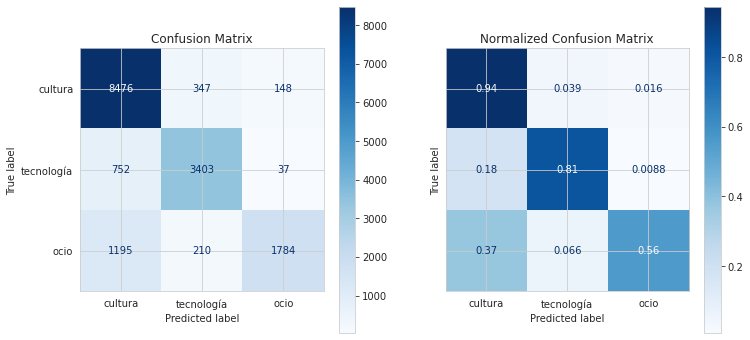

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.6816,"(CountVectorizer(), LogisticRegression(max_ite..."
1,logistic,0.7101,"(TfidfVectorizer(), LogisticRegression(max_ite..."
2,multinomial_nb,0.7211,"(CountVectorizer(), MultinomialNB())"
3,multinomial_nb,0.6510,"(TfidfVectorizer(), MultinomialNB())"
4,bernoulli_nb,0.6951,"(CountVectorizer(), BernoulliNB())"


The model has a degree of accuracy of 69.51%.


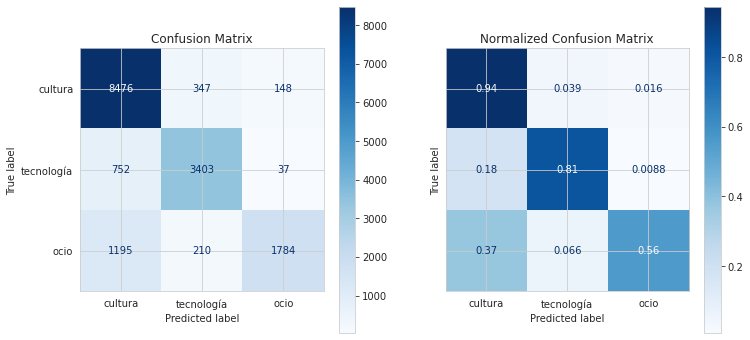

,MODEL,ACCURACY,ESTIMATOR
0,logistic,0.6816,"(CountVectorizer(), LogisticRegression(max_ite..."
1,logistic,0.7101,"(TfidfVectorizer(), LogisticRegression(max_ite..."
2,multinomial_nb,0.7211,"(CountVectorizer(), MultinomialNB())"
3,multinomial_nb,0.6510,"(TfidfVectorizer(), MultinomialNB())"
4,bernoulli_nb,0.6951,"(CountVectorizer(), BernoulliNB())"
5,bernoulli_nb,0.6951,"(TfidfVectorizer(), BernoulliNB())"


In [52]:
def my_bernoulli_nb(results, features_data, target_data, vectorizer, show_msg=False):
    input = [('vectorizer', vectorizer(analyzer='word', max_features=None)), ('model', BernoulliNB())]

    estimator, score = my_cross_validate(estimator=Pipeline(steps=input), X=features_data, y=target_data, show_msg=show_msg)

    new_df = pd.DataFrame(data={'MODEL': ['bernoulli_nb'], 'ACCURACY': [score], 'ESTIMATOR': [estimator]})

    results = pd.concat([results, new_df], ignore_index=True)
    return results, estimator


results, clf = my_bernoulli_nb(results, corpus, target_data, CountVectorizer, True)
display(results)

results, clf = my_bernoulli_nb(results, corpus, target_data, TfidfVectorizer, True)
display(results)

### Resume

In [53]:
results_sort = results.sort_values(by=['ACCURACY'], ascending=[False])
results_sort

,MODEL,ACCURACY,ESTIMATOR
2,multinomial_nb,0.7211,"(CountVectorizer(), MultinomialNB())"
1,logistic,0.7101,"(TfidfVectorizer(), LogisticRegression(max_ite..."
4,bernoulli_nb,0.6951,"(CountVectorizer(), BernoulliNB())"
5,bernoulli_nb,0.6951,"(TfidfVectorizer(), BernoulliNB())"
0,logistic,0.6816,"(CountVectorizer(), LogisticRegression(max_ite..."
3,multinomial_nb,0.6510,"(TfidfVectorizer(), MultinomialNB())"


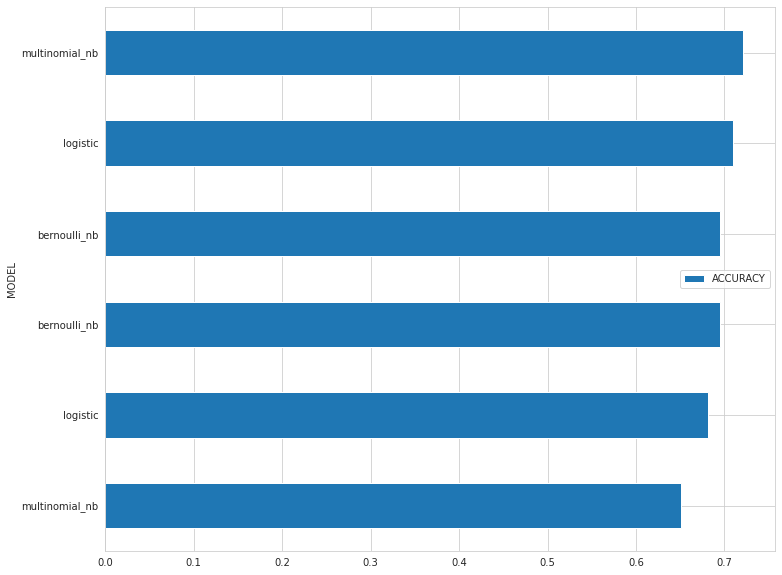

In [54]:
plt.rc("figure", figsize=(12, 10))
results_sort[::-1].set_index('MODEL').plot.barh(rot=0)

In [55]:
print(f'Best tentative algorithm "{results_sort.iloc[0].MODEL}" with ACCURACY={results_sort.iloc[0].ACCURACY}".')

Best tentative algorithm "multinomial_nb" with ACCURACY=0.7211".


### Export

In [56]:
best_estimator = results_sort.iloc[0].ESTIMATOR

Save to file.

In [57]:
pkl_filename = f'{resources_prefix}_resources/best_estimator.pkl'

with open(pkl_filename, 'wb') as file:
    pickle.dump(best_estimator, file)

Load from file.

In [58]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [59]:
pickle_model

Pipeline(steps=[('vectorizer', CountVectorizer()), ('model', MultinomialNB())])

## Deep Learning

Cuda version.

In [60]:
print(f"Tensorflow version: {tf.__version__}")
print(f"Cuda version: {build.build_info['cuda_version']}")
print(f"Cudnn version: {build.build_info['cudnn_version']}")

Tensorflow version: 2.8.2
Cuda version: 11.1
Cudnn version: 8


**Enable GPU**

- The environment must be created with a version of Python compatible with the operation of Tensorflow and its use of the GPU (https://www.tensorflow.org/install/pip#virtual-environment-install).
- Before installing tensorflow-gpu you must install CUDA Toolkit and cuDNN from official NVIDIA site.
- Anaconda must be restarted after installing tensorflow-gpu.

In [61]:
# !conda install -y tensorflow-gpu keras-gpu

In [62]:
if len(tf.config.list_physical_devices('GPU')) == 0:
    raise SystemExit("Restart Anaconda to activate the GPU.")
else:
    print('GPU activated.')

GPU activated.


Available hardware.

In [63]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available hardware details.

In [64]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13187106723256872562
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6456081911308164143
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

### Vectorizer

Se debe seleccionar `Tokenizer`[1], `TextVectorization`[2] o `spacy`[3].

[1] y [2]: Se genera una capa de incrustación.

[3]: No es necesario generar una capa de incrustación.

In [65]:
# Tokenizer => 'tokenizer'
# TextVectorization => 'text_vectorization'
# spacy => 'spacy'

vectorizer = 'spacy'

Se puede restringir la cantidad de muestras, el número de palabras del diccionario y el máximo de palabras tomadas por cada observación.

In [66]:
# cantidad de muestras
# None: all
print('Total de muestras:', len(corpus))
max_samples = None

# número de palabras del diccionario
# None: all
max_tokens = None

# máximo de palabras tomadas por cada observación
# max_len: all
max_len = max([len(sentence.split(sep=' ')) for sentence in corpus])
print('Máxima cantidad de palabras por muestras:', max_len)
max_len = max_len

Total de muestras: 16352
Máxima cantidad de palabras por muestras: 54


In [67]:
if max_samples != None:
    print('Before:', corpus.shape, target_data.shape)

    li = range(0, len(corpus)-1)
    i_rand = random.sample(li, max_samples)

    # Se convierte a series para ejecutar el iloc a partir de un listado de indexs.
    corpus = pd.Series(data=corpus)
    target_data = pd.Series(data=target_data)

    corpus = corpus.iloc[i_rand].values
    target_data = target_data.iloc[i_rand].values

    print('After:', corpus.shape, target_data.shape)

    del i_rand

#### Tokenizer

Se utiliza `Tokenizer` para `normalizar` los datos y que puedan ser utilizado en `Long Short Term Memory Networks (LSTMs)`.

Tokenizer elimina por defecto los signos de puntuación y convierte las mayúsculas en minúsculas.

Para el idioma `Ingles`, son mejores los siguientes parametros:
- filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n'
- lower = False

In [68]:
class MyTokenizer(BaseEstimator, TransformerMixin):
    def fit(self, corpus, y=None):
        self.Tokenizer = Tokenizer(num_words=max_tokens)
        self.Tokenizer.fit_on_texts(corpus)

        return self

    def transform(self, corpus, y=None):
        # Transformando cada texto en una secuencia de números enteros.
        vector = self.Tokenizer.texts_to_sequences(corpus)

        # Rellenando con 0 los valores finales de cada secuencia.
        vector = pad_sequences(sequences=vector, maxlen=max_len, padding='post', truncating='post', value=0.0)

        return vector


if vectorizer == 'tokenizer':
    tokenizer = MyTokenizer()
    features_data_vectorized = tokenizer.fit_transform(corpus)
    display(features_data_vectorized.shape)

In [69]:
if vectorizer == 'tokenizer':
    pkl_filename = f'{resources_prefix}_resources/tokenizer.pkl'

    with open(pkl_filename, 'wb') as file:
        dill.dump(tokenizer, file)

    with open(pkl_filename, 'rb') as file:
        tokenizer = dill.load(file)

Vocabulary

In [70]:
if vectorizer == 'tokenizer':
    tokenizer_vocabulary = tokenizer.Tokenizer.word_index
    display(tokenizer_vocabulary)

Obtener `corpus` a partir de los vectores generados.

In [71]:
if vectorizer == 'tokenizer':
    display('original:')
    display(corpus[0])

    display('generado:')
    display(tokenizer.Tokenizer.sequences_to_texts([features_data_vectorized[0]])[0])

In [72]:
if vectorizer == 'tokenizer':
    first_layer = Embedding(input_dim=len(tokenizer_vocabulary) + 1, output_dim=128, input_length=features_data_vectorized.shape[1])

#### TextVectorization

In [73]:
if vectorizer == 'text_vectorization':
    vectorize_layer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_len)

    # Genera el vocabulario
    vectorize_layer.adapt(corpus)

    features_data_vectorized = vectorize_layer(corpus).numpy()
    display(features_data_vectorized.shape)

Vocabulary

Se debe actualizar a un diccionario para obtener la misma estructura de datos que `Tokenizer`.

In [74]:
if vectorizer == 'text_vectorization':
    vectorize_vocabulary = {word: i for i, word in enumerate(vectorize_layer.get_vocabulary())}
    display(vectorize_vocabulary)

In [75]:
if vectorizer == 'text_vectorization':
    first_layer = Embedding(input_dim=len(vectorize_vocabulary) + 1, output_dim=128, input_length=features_data_vectorized.shape[1])

#### Spacy

En caso que el número de palabras del diccionario se encuentre restringido, es necesario crear un nuevo `corpus` con las palabras más importantes del diccionario. Para el proceso nos ayudamos de `Tokenizer`.

In [76]:
if vectorizer == 'spacy' and max_tokens != None:
    tokenizer = Tokenizer(num_words=max_tokens)
    tokenizer.fit_on_texts(corpus)

    print('All vocabulary:', len(tokenizer.word_index))

    features_data_vectorized = tokenizer.texts_to_sequences(corpus)
    corpus = tokenizer.sequences_to_texts(features_data_vectorized)

    del tokenizer

    # Se eliminan los elementos vacíos.
    empty_indexs = [i for i, text in enumerate(corpus) if text == '']

    # Se convierte a series para ejecutar el drop a partir de un listado de indexs.
    corpus = pd.Series(data=corpus)
    target_data = pd.Series(data=target_data)

    corpus = corpus.drop(index=empty_indexs).values
    target_data = target_data.drop(index=empty_indexs).values

    print(len(corpus), len(target_data))

In [77]:
def spacy_vectorizer(corpus, max_len):
    n = len(corpus)
    nlp_len = len(nlp(text='a').vector)
    # Se puede inicilizar en zeros (la memoria crece poco a poco)
    # Si se inicializa en ones, se reserva toda la memoria inmediatamente, 1.0 ocupa más espacio que 0.0
    features_data_vectorized = np.ones(shape=(n, max_len, nlp_len),
                                       dtype=np.float32)

    for i in range(0, n):
        doc = nlp(corpus[i])

        vector = [tok.vector for tok in doc][:max_len]
        vector = np.array(object=vector, dtype=np.float32)

        # Se rellenan con ceros cuando la cantidad de palabras de la oración sea menor que el máximo.
        pad_vector = np.zeros(shape=(max_len-vector.shape[0], nlp_len), dtype=np.float32)

        vector = np.concatenate((vector, pad_vector), axis=0)
        
        features_data_vectorized[i] = vector

        print("\r Items {0} of {1}".format(i, n), end='')

    return features_data_vectorized


if vectorizer == 'spacy':
    features_data_vectorized = spacy_vectorizer(corpus, max_len)
    display(features_data_vectorized.shape)

 Items 16351 of 16352

(16352, 54, 96)

In [78]:
if vectorizer == 'spacy':
    first_layer = Input(shape=features_data_vectorized.shape[1:])

### Keras

In [79]:
# lstm => Long Short Term Memory Networks (LSTM)
# cnn => Convolutional Neural Networks (CNN)

keras_net_type = 'cnn'

`Targets` to `one-hot-encoding`.

In [80]:
target_data[:10]

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


[0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0]
Categories (3, float64): [0.0, 1.0, 2.0]

In [81]:
categorical_target_data = np_utils.to_categorical(target_data)
categorical_target_data[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

Los datos de entrenamiento son creados independientemente del `vectorizer` seleccionado.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(features_data_vectorized, categorical_target_data, test_size=0.2)

In [83]:
earlystop = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)

In [84]:
keras_file_path = f'{resources_prefix}_resources/keras.hdf5'
checkpoint = ModelCheckpoint(filepath=keras_file_path, verbose=1, save_weights_only=True, save_freq='epoch')

In [85]:
if keras_net_type == 'lstm':
    # if error => !conda install -y numpy=1.19

    with tf.device("/GPU:0"):
        # clasificación binaria: activation sigmoid en la ultima capa y binary_crossentropy como loss.
        # clasificación multiclase: activation softmax en la ultima capa y categorical_crossentropy como loss.

        keras_model = Sequential([first_layer,

                                 LSTM(units=100, dropout=0.2, return_sequences=True),

                                 LSTM(units=100, dropout=0.2, return_sequences=True),

                                 LSTM(units=100, dropout=0.2, return_sequences=True),

                                 LSTM(units=100, dropout=0.2, return_sequences=True),

                                 LSTM(units=100, dropout=0.2, return_sequences=False),

                                #  Dense(units=100, activation='relu', kernel_constraint=maxnorm(max_value=3)),
                                #  Dense(units=100, activation='relu', kernel_constraint=maxnorm(max_value=3)),
                                #  Dropout(rate=0.2),

                                 Dense(units=3, activation='softmax')])

    #   categorical_crossentropy: Retorna la clase predecida, en la última capa Dense units debe ser 1.
    #   sparse_categorical_crossentropy: Retorna las probabilidades de cada clase, en la última capa Dense units debe ser el número de clases.

        keras_model.compile(optimizer=Adam(learning_rate=0.01),       # optimizer
                            loss='categorical_crossentropy',          # función de pérdida o coste
                            metrics=['accuracy'])                     # Métricas para observar la evolución del entrenamiento del modelo (precisión)

        try:
            keras_model.load_weights(filepath=keras_file_path)
            print('Weights loaded!\n')
        except:
            print('Weights unloaded!\n')
            
        display(keras_model.summary())

        # Se debe ajustar el modelo dentro del ámbito, sino se ejecutará en dependencia si se activó o no la GPU
        # Agregar checkpoint en callbacks si es necesario, tener en cuenta que debe ser un checkpoint por tipo de red.
        historial_train = keras_model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test), callbacks=[checkpoint])

In [86]:
if keras_net_type == 'cnn':
    with tf.device("/GPU:0"):
        # clasificación binaria: activation sigmoid en la ultima capa y binary_crossentropy como loss.
        # clasificación multiclase: activation softmax en la ultima capa y categorical_crossentropy como loss.

        # filters: número de filtros de salida en la convolución
        # kernel_size: altura y ancho de la ventana de convolución 2D, depende de la dimensión de la imágen
        # kernel_size: 3x3 imagenes pequeñas, 5x5 medianas, 7x7 grandes o videos

        keras_model = Sequential([first_layer,

                                  Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
                                  MaxPooling1D(),
                                  Dropout(rate=0.2),

                                  Conv1D(filters=200, kernel_size=3, padding='same', activation='relu'),
                                  MaxPooling1D(),
                                  Dropout(rate=0.2),

                                  Conv1D(filters=300, kernel_size=3, padding='same', activation='relu'),
                                  MaxPooling1D(),
                                  Dropout(rate=0.2),

                                  Flatten(),

                                  Dense(units=100, activation='relu', kernel_constraint=maxnorm(max_value=3)),
                                  Dense(units=100, activation='relu', kernel_constraint=maxnorm(max_value=3)),
                                  Dropout(rate=0.2),

                                  Dense(units=3, activation='softmax')])

    #   categorical_crossentropy: Retorna la clase predecida, en la última capa Dense units debe ser 1.
    #   sparse_categorical_crossentropy: Retorna las probabilidades de cada clase, en la última capa Dense units debe ser el número de clases.

        keras_model.compile(optimizer=Adam(learning_rate=0.001),      # optimizer
                            loss='categorical_crossentropy',          # función de pérdida
                            metrics=['accuracy'])                     # Métricas para observar la evolución del entrenamiento del modelo (precisión)

        display(keras_model.summary())

        # Se debe ajustar el modelo dentro del ámbito, sino se ejecutará en dependencia si se activó o no la GPU
        historial_train = keras_model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test), callbacks=[checkpoint])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 54, 100)           28900     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 100)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 27, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 200)           60200     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 200)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 13, 200)           0

None

Epoch 1/20
409/409 [==============================] - ETA: 0s - loss: 0.9875 - accuracy: 0.5550
Epoch 1: saving model to /content/drive/MyDrive/Machine Learning/Notebooks/0501_NLP - News Classifier/_resources/keras.hdf5
409/409 [==============================] - 16s 10ms/step - loss: 0.9875 - accuracy: 0.5550 - val_loss: 0.9562 - val_accuracy: 0.5720
Epoch 2/20
407/409 [============================>.] - ETA: 0s - loss: 0.9593 - accuracy: 0.5652
Epoch 2: saving model to /content/drive/MyDrive/Machine Learning/Notebooks/0501_NLP - News Classifier/_resources/keras.hdf5
409/409 [==============================] - 3s 8ms/step - loss: 0.9594 - accuracy: 0.5652 - val_loss: 0.9409 - val_accuracy: 0.5717
Epoch 3/20
401/409 [============================>.] - ETA: 0s - loss: 0.9494 - accuracy: 0.5661
Epoch 3: saving model to /content/drive/MyDrive/Machine Learning/Notebooks/0501_NLP - News Classifier/_resources/keras.hdf5
409/409 [==============================] - 3s 6ms/step - loss: 0.9497 - accu

In [87]:
hist = pd.DataFrame(historial_train.history)
hist['epoch'] = historial_train.epoch
hist

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.987504,0.555003,0.956220,0.571996,0
1,0.959433,0.565171,0.940890,0.571691,1
2,0.949692,0.566470,0.950878,0.571385,2
3,0.927029,0.570828,0.936312,0.574136,3
4,0.896417,0.595291,0.968759,0.538979,4
5,0.865269,0.613562,0.919446,0.590034,5
6,0.821994,0.642229,0.918649,0.594619,6
7,0.776262,0.662335,0.942399,0.587894,7
8,0.725611,0.688785,0.944740,0.567716,8
9,0.677425,0.712407,0.981393,0.561602,9


Metrics.

In [88]:
keras_model.metrics_names

['loss', 'accuracy']

Predict.

In [89]:
keras_model.predict(X_test[:10])

array([[0.97740024, 0.01331821, 0.00928151],
       [0.73397106, 0.18256915, 0.08345982],
       [0.8300322 , 0.07119209, 0.09877569],
       [0.16090897, 0.7870426 , 0.0520484 ],
       [0.21474107, 0.38512373, 0.40013525],
       [0.7057441 , 0.04456538, 0.24969049],
       [0.9638607 , 0.00365996, 0.03247938],
       [0.31581476, 0.37210897, 0.3120763 ],
       [0.6472487 , 0.32637763, 0.02637365],
       [0.6342682 , 0.00714144, 0.3585904 ]], dtype=float32)

Analyzing the training and evaluation data.

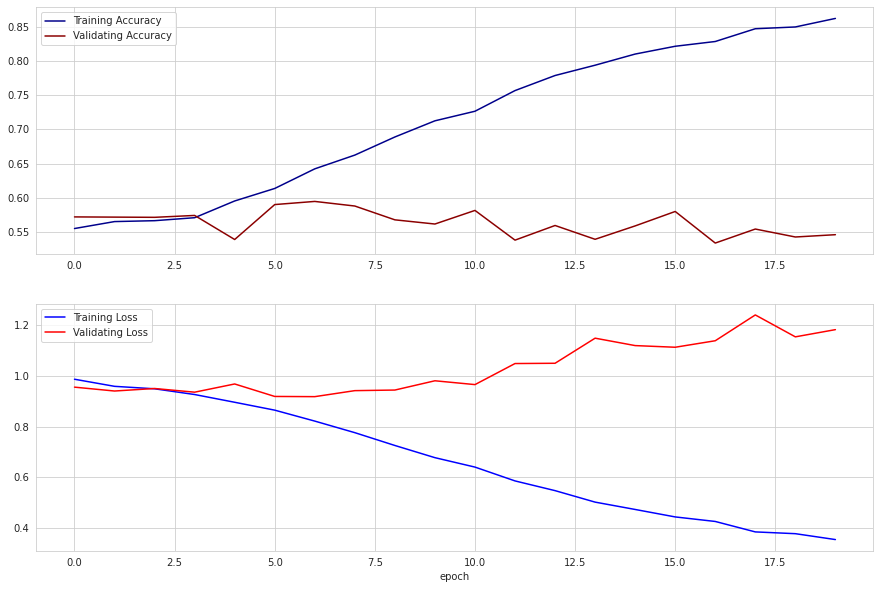

In [90]:
def plot_metrics(historial_train):
    plt.figure(figsize=(15, 10))

    acc = historial_train.history['accuracy']
    val_acc = historial_train.history['val_accuracy']
    loss = historial_train.history['loss']
    val_loss = historial_train.history['val_loss']

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(acc, color='darkblue', label='Training Accuracy')
    ax1.plot(val_acc, color='darkred', label='Validating Accuracy')
    ax1.legend()

    ax1 = plt.subplot(2, 1, 2)
    ax1.set_xlabel('epoch')
    ax1.plot(loss, color='blue', label='Training Loss')
    ax1.plot(val_loss, color='red', label='Validating Loss')
    ax1.legend()


plot_metrics(historial_train)

Model evaluation.

In [91]:
loss_train, accuracy_train = keras_model.evaluate(X_train, y_train)
loss_test, accuracy_test = keras_model.evaluate(X_test, y_test)

103/103 [==============================] - 0s 4ms/step - loss: 1.1836 - accuracy: 0.5460


#### Export

Save to file.

In [92]:
h5_filename = f'{resources_prefix}_resources/keras_model.h5'
keras_model.save(h5_filename)

Load from file.

In [93]:
keras_model = load_model(h5_filename)
keras_model